In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
from torchvision import transforms
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from piqa import MS_SSIM

KeyboardInterrupt: 

In [ ]:
# use CUDA processors if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
def get_img_path(digit, i):
    # get the image path given the digit and the index of the image within the digit
    # eg. get_img_path(4, 12) denotes the 13th image of digit 4
    if digit == 0:
        img_num = 9000
    else:
        img_num = (digit - 1) * 1000
    img_num += (i+1)
    return f'../data/labels/{digit}/image{img_num}.png'


def gather_data(exp_type: str, detect_type: str, feature_name: str):
    # prepare feature data and image paths
    features = None
    image_paths = []
    digits = []
    for digit in range(10):
        fpath = f'../data/features/{exp_type}/{detect_type}/{feature_name}/{feature_name}{digit}.csv'
        data = pd.read_csv(fpath, header=None)

        for i in range(len(data)):
            dig = data[0][i]
            image_paths.append(get_img_path(dig, i))
            digits += [dig]

        data = data.drop(0, axis=1)
        if features is None:
            features = data.to_numpy()
        else:
            features = np.append(features, data.to_numpy(), axis=0)

    features = torch.tensor(features.astype(np.float32)).cuda()
    return features, image_paths, digits

# define data transformations
def feature_transform(x: torch.Tensor):
    # standardizes the features of a given data point
    mean = x.mean()
    std = x.std()
    return x.sub(mean).div(std)


def img_transform(y: str):
    # transforms an image path to a usable tensor
    image = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    convert_tensor = A.Compose([A.ToFloat(max_value=255), ToTensorV2()])
    try:
        thingy = convert_tensor(image=image)['image']
        return thingy.cuda()
    except Exception as e:
        print(e)
        raise Exception(f"cannot load image: {y}")


def digit_transform(y: int):
    return y


# create Datasets and DataLoaders
class ReconstructionData(Dataset):
    def __init__(self, raw_features: torch.Tensor, labels: list, feature_transform, label_transform: None):
        self.features = raw_features
        self.labels = labels
        self.feature_transform = feature_transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        data = self.feature_transform(self.features[idx])
        label = self.label_transform(self.labels[idx])
        return data, label


def prep_data(features, labels, val_size, feature_transform, label_transform, batch_size):
    # create train and validation dataloaders
    train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=val_size)
    train_data = ReconstructionData(train_features, train_labels, feature_transform, label_transform)
    val_data = ReconstructionData(val_features, val_labels, feature_transform, label_transform)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    return train_dataloader, val_dataloader


class ImgReconstructNN(nn.Module):
    def __init__(self):
        super(ImgReconstructNN, self).__init__()
        self.reconstruct_stack = nn.Sequential(
            nn.Linear(300, 1024),
            nn.PReLU(),
            nn.Linear(1024, 4096),
            nn.PReLU(),
            nn.Linear(4096, (4*28)*(4*28)),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 4*28, 4*28)),
            nn.Conv2d(1,4,4,padding=2),
            nn.MaxPool2d(2),
            nn.Conv2d(4,1,2,padding=1),
            nn.MaxPool2d(2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.reconstruct_stack(x)
        return logits


class ImgReconstructClassifyNN(nn.Module):
    def __init__(self):
        super(ImgReconstructClassifyNN, self).__init__()
        self.reconstruct_classify_stack = nn.Sequential(
            nn.Linear(300, 2048),
            nn.PReLU(),
            nn.Linear(2048, 2048),
            nn.PReLU(),
            nn.Linear(2048, (8*28)*(8*28)),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 8*28, 8*28)),
            nn.Conv2d(1, 1, 8, padding=4),
            nn.MaxPool2d(2),
            nn.Conv2d(1, 1, 4, padding=2),
            nn.MaxPool2d(2),
            nn.Conv2d(1, 1, 2, padding=1),
            nn.MaxPool2d(2),
            nn.Sigmoid(),
            nn.Conv2d(1, 10, 5),
            nn.MaxPool2d(2),
            nn.PReLU(),
            nn.Conv2d(10, 20, 5),
            nn.MaxPool2d(2),
            nn.PReLU(),
            nn.Linear(320, 50),
            nn.PReLU(),
            nn.Linear(50, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.reconstruct_classify_stack(x)
        return logits


# Training loop
def train_loop(dataloader: DataLoader, val_dataloader: DataLoader, model: nn.Module, loss_fn, optimizer, print_loss: bool, train_losses: list, val_losses: list) -> list:
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches
    train_losses.append(train_loss)
    if print_loss:
        print(f"Avg batch loss: {train_loss:>8f}")

    model.eval()
    with torch.no_grad():
        test_loss = 0
        for (X, y) in val_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
        train_loss /= num_batches
        val_losses.append(test_loss)
    model.train()

    return train_losses, val_losses


def reconstruct_test_loop(dataloader, model, loss_fn):
    model.eval()
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            print(f"batch: {batch+1}")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_ssim += ssim(pred, y).item()
            test_psnr += psnr(pred, y).item()

            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[0]
            orig_img = transform(orig_data)
            pred_data = pred[0]
            pred_img = transform(pred_data)
            diff_data = torch.abs(pred_data - orig_data)
            diff_img = transform(diff_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print("difference:")
            display(diff_img)
            print()

    test_loss /= num_batches
    test_psnr /= num_batches
    test_ssim /= num_batches
    print(f"Avg batch loss: {test_loss:>8f}")
    print(f"Avg batch PSNR: {test_psnr:>8f}")
    print(f"Avg batch SSIM: {test_ssim:>8f}")
    return model, test_loss, test_psnr, test_ssim


def reconstruct_test_loop(dataloader, model, loss_fn):
    model.eval()
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            print(f"batch: {batch+1}")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_ssim += ssim(pred, y).item()
            test_psnr += psnr(pred, y).item()

            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[0]
            orig_img = transform(orig_data)
            pred_data = pred[0]
            pred_img = transform(pred_data)
            diff_data = torch.abs(pred_data - orig_data)
            diff_img = transform(diff_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print("difference:")
            display(diff_img)
            print()

    test_loss /= num_batches
    test_psnr /= num_batches
    test_ssim /= num_batches
    print(f"Avg batch loss: {test_loss:>8f}")
    print(f"Avg batch PSNR: {test_psnr:>8f}")
    print(f"Avg batch SSIM: {test_ssim:>8f}")
    return model, test_loss, test_psnr, test_ssim


def reconstruct_test_loop(dataloader, model, loss_fn):
    model.eval()
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            print(f"batch: {batch+1}")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_ssim += ssim(pred, y).item()
            test_psnr += psnr(pred, y).item()

            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[0]
            orig_img = transform(orig_data)
            pred_data = pred[0]
            pred_img = transform(pred_data)
            diff_data = torch.abs(pred_data - orig_data)
            diff_img = transform(diff_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print("difference:")
            display(diff_img)
            print()

    test_loss /= num_batches
    test_psnr /= num_batches
    test_ssim /= num_batches
    print(f"Avg batch loss: {test_loss:>8f}")
    print(f"Avg batch PSNR: {test_psnr:>8f}")
    print(f"Avg batch SSIM: {test_ssim:>8f}")
    return model, test_loss, test_psnr, test_ssim


def train_model(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_losses = []
    val_losses = []
    for t in range(epochs):
        print_loss = False
        if (t % 8 == 7) or (t==0):
            print_loss = True
            print("-------------------------------")
            print(f"Epoch {t+1}")
        train_losses, val_losses = train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, print_loss, train_losses, val_losses)
    print("Done!")
    return train_losses, val_losses


def plot_loss(losses: list, val: bool) -> None:
    losses = np.array(torch.tensor(losses).cpu())
    plt.plot(losses, color='red')
    plt.ylabel('Average Batch Loss') #set the label for y axis
    plt.xlabel('Epoch') #set the label for x-axis
    if val:
        plt.title("Validation Loss over Epochs") #set the title of the graph
    else:
        plt.title("Training Loss over Epochs") #set the title of the graph
    plt.show() #display the graph


l1 = nn.L1Loss()
class L1_SSIM_loss(MS_SSIM):
    def forward(self, x, y):
        return (0.5 * (1. - super().forward(x, y))) + (0.5 * l1.forward(x, y))


def reconstruct(exp_type, detect_type, feature_name, batch_size, val_size, epochs, loss_fn, learning_rate):
    print(f"\nTRAINING RECONSRTUCTION MODEL FOR: {feature_name}\n")
    print("PART 1")
    features, image_paths, digits = gather_data(exp_type, detect_type, feature_name)
    print("PART 2")
    train_dataloader, val_dataloader = prep_data(features, image_paths, val_size, feature_transform, img_transform, batch_size)
    print("PART 3")
    model = ImgReconstructNN().to(device)
    print(model)
    print("PART 4")
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    print("PART 5")
    train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs)
    print("PART 6")
    plot_loss(train_losses, False)
    plot_loss(val_losses, True)
    print("PART 7")
    model, val_loss, val_psnr, val_ssim = reconstruct_test_loop(val_dataloader, model, loss_fn)
    saved_model_loc = f'../data/features/{exp_type}/{detect_type}/{feature_name}/reconstruct_model.pt'
    torch.save(model.state_dict(), saved_model_loc)
    saved_losses_loc = f'../data/features/{exp_type}/{detect_type}/{feature_name}/reconstruct_losses.pt'
    torch.save((train_losses, val_loss), saved_losses_loc)
    return val_loss, val_psnr, val_ssim

def classify_one_model(exp_type, detect_type, feature_name, batch_size, val_size, epochs, loss_fn, learning_rate):
    print(f"\nTRAINING CLASSIFICATION MODEL FOR: {feature_name}\n")
    print("PART 1")
    features, image_paths, digits = gather_data(exp_type, detect_type, feature_name)
    print("PART 2")
    train_dataloader, val_dataloader = prep_data(features, digits, val_size, feature_transform, digit_transform, batch_size)
    print("PART 3")
    model = ImgReconstructClassifyNN().to(device)
    print(model)
    print("PART 4")
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    print("PART 5")
    train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs)
    print("PART 6")
    plot_loss(train_losses, False)
    plot_loss(val_losses, True)
    print("PART 7")
    model, val_loss, val_psnr, val_ssim = test_loop(val_dataloader, model, loss_fn)
    saved_model_loc = f'../data/features/{exp_type}/{detect_type}/{feature_name}/reconstruct_model.pt'
    torch.save(model.state_dict(), saved_model_loc)
    saved_losses_loc = f'../data/features/{exp_type}/{detect_type}/{feature_name}/reconstruct_losses.pt'
    torch.save((train_losses, val_loss), saved_losses_loc)
    return val_loss, val_psnr, val_ssim



TRAINING RECONSRTUCTION MODEL FOR: annd40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.525184
-------------------------------
Epoch 8
Avg batch loss: 0.314944
-------------------------------
Epoch 16
Avg batch 

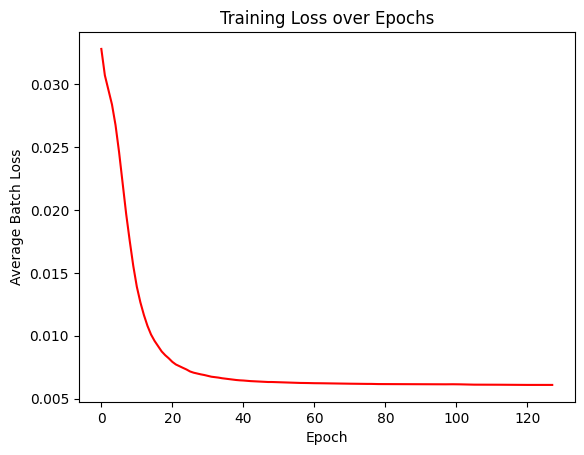

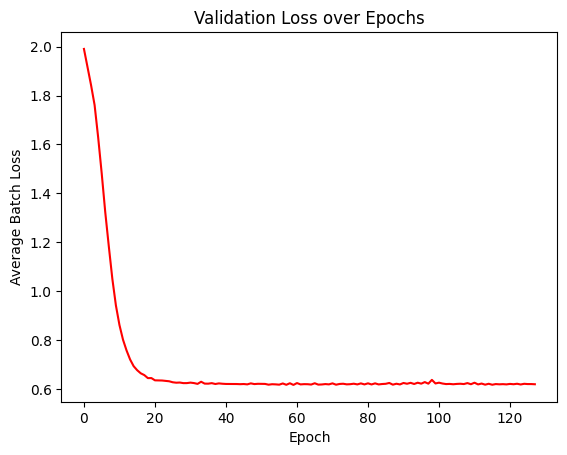

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.154676
Avg batch PSNR: 13.789353
Avg batch SSIM: 0.431064

TRAINING RECONSRTUCTION MODEL FOR: 0p5tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.542491
-------------------------------
Epoch

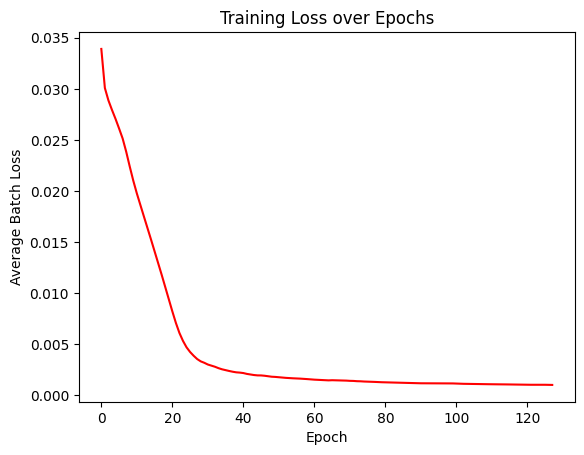

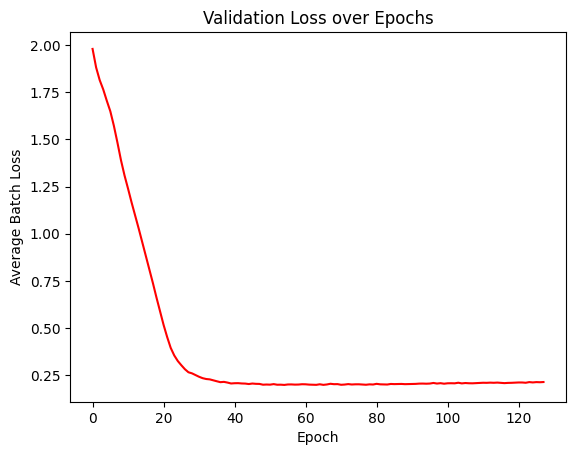

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.053828
Avg batch PSNR: 18.304856
Avg batch SSIM: 0.823890

TRAINING RECONSRTUCTION MODEL FOR: 100tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.485751
-------------------------------
Epoch

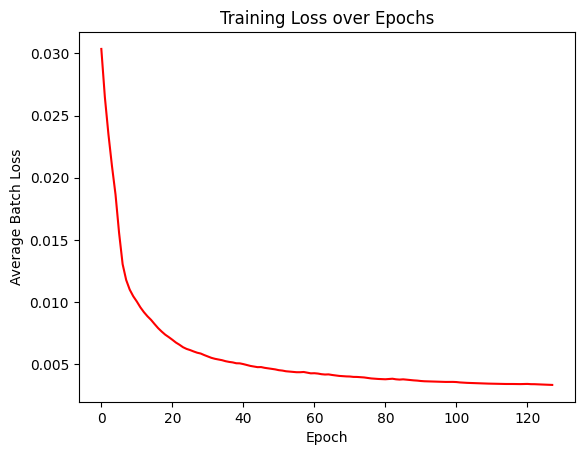

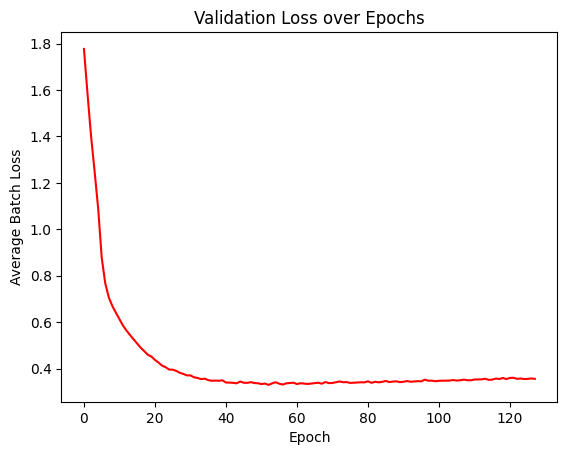

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.088986
Avg batch PSNR: 16.344980
Avg batch SSIM: 0.681561

TRAINING RECONSRTUCTION MODEL FOR: 10tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.466580
-------------------------------
Epoch 

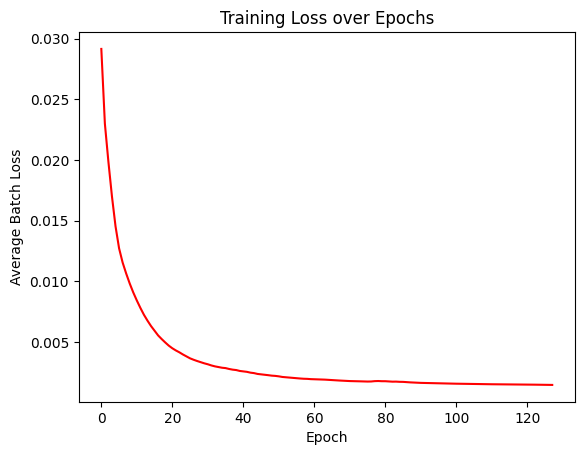

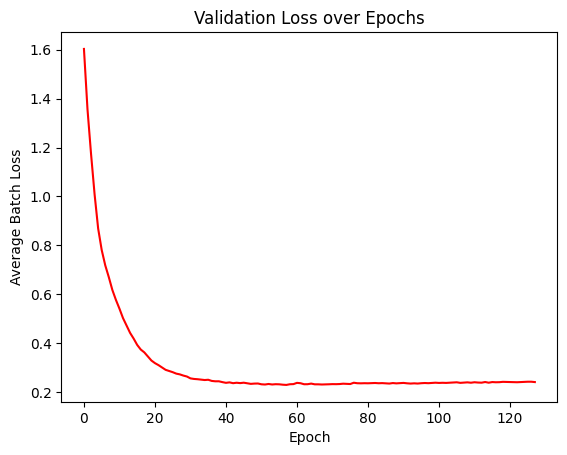

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.060477
Avg batch PSNR: 18.153276
Avg batch SSIM: 0.803112

TRAINING RECONSRTUCTION MODEL FOR: 1tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.521333
-------------------------------
Epoch 8

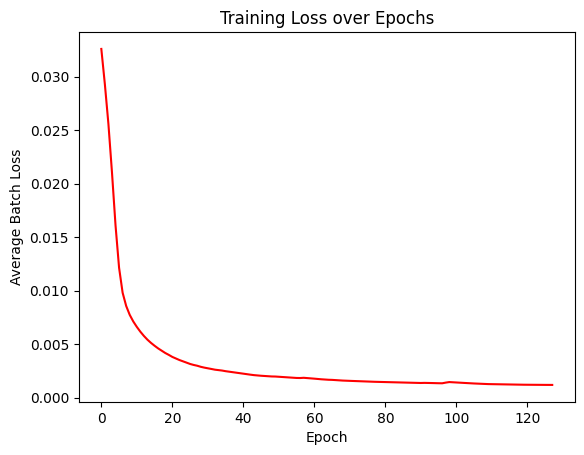

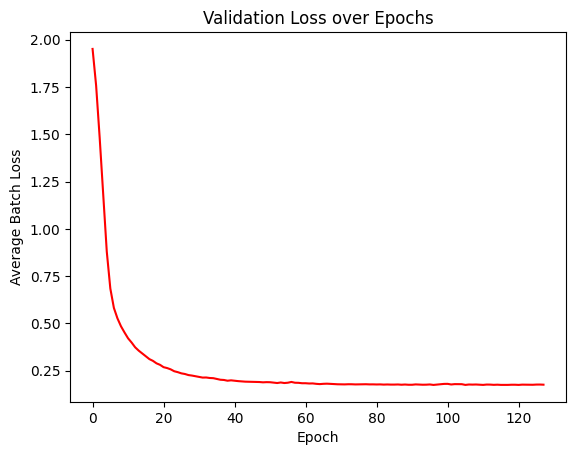

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.044085
Avg batch PSNR: 19.399435
Avg batch SSIM: 0.854508

TRAINING RECONSRTUCTION MODEL FOR: 200tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.481538
-------------------------------
Epoch

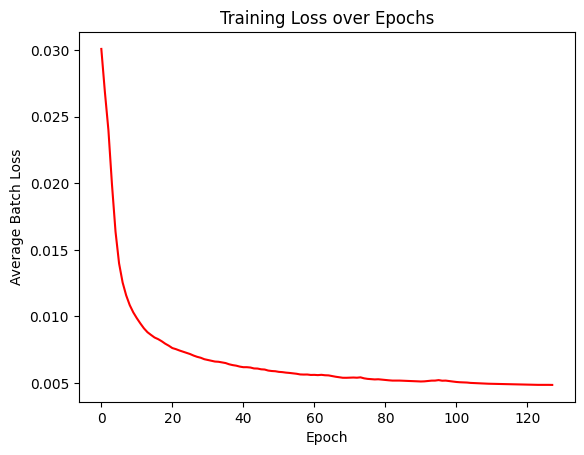

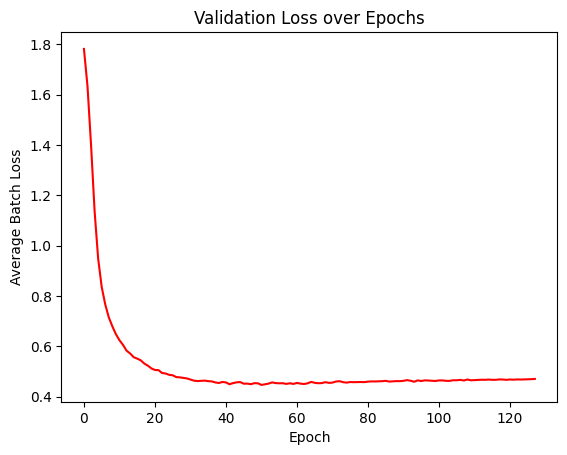

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.117703
Avg batch PSNR: 14.980888
Avg batch SSIM: 0.566594

TRAINING RECONSRTUCTION MODEL FOR: 20tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.520937
-------------------------------
Epoch 

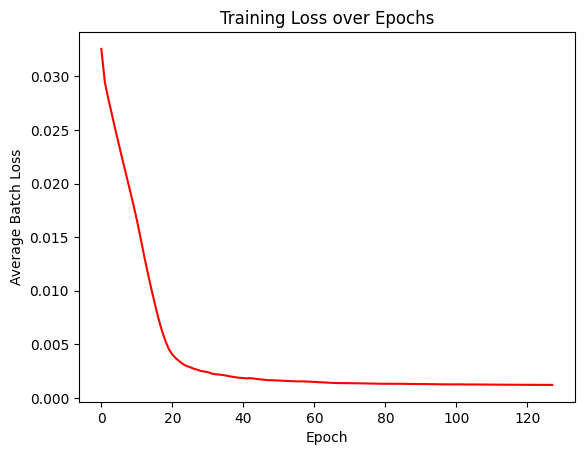

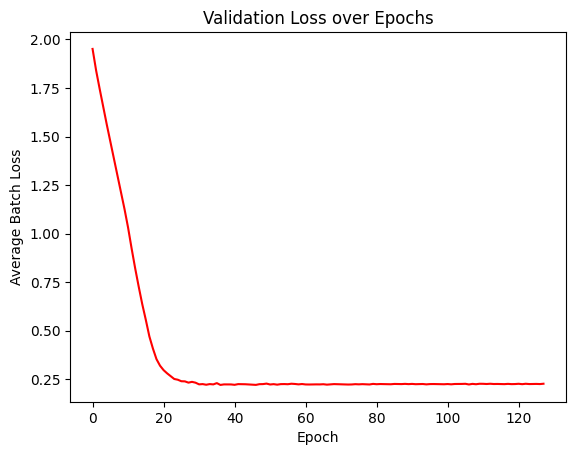

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.056799
Avg batch PSNR: 18.339674
Avg batch SSIM: 0.812986

TRAINING RECONSRTUCTION MODEL FOR: 2tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.523982
-------------------------------
Epoch 8

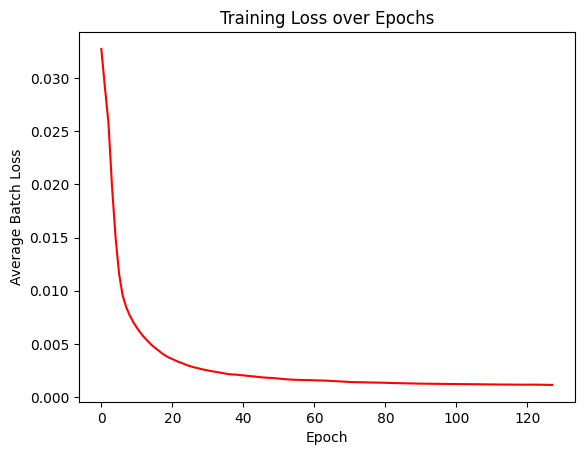

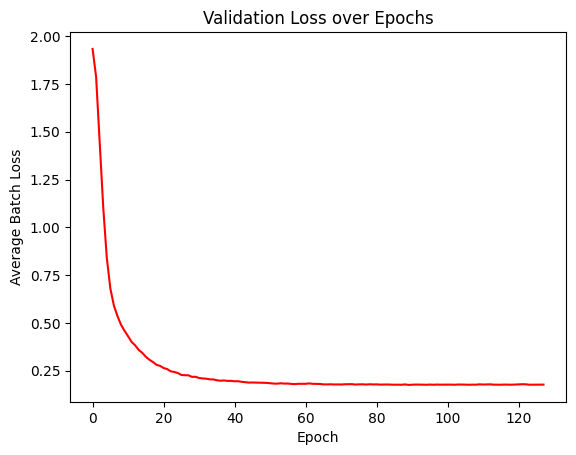

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.044297
Avg batch PSNR: 19.205534
Avg batch SSIM: 0.852699

TRAINING RECONSRTUCTION MODEL FOR: 50tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.533700
-------------------------------
Epoch 

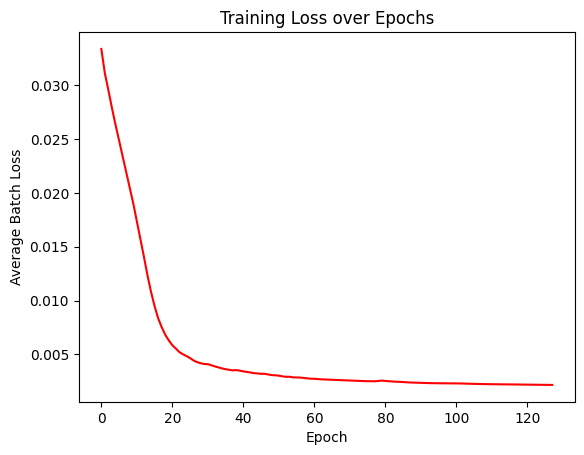

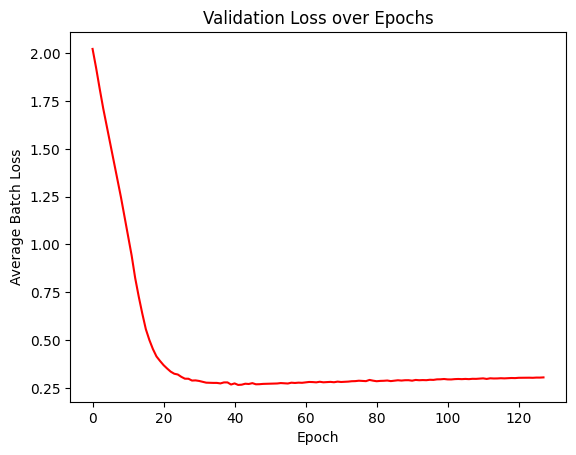

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.076280
Avg batch PSNR: 16.879792
Avg batch SSIM: 0.739245

TRAINING RECONSRTUCTION MODEL FOR: nnfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.497589
-------------------------------
Epoch 8

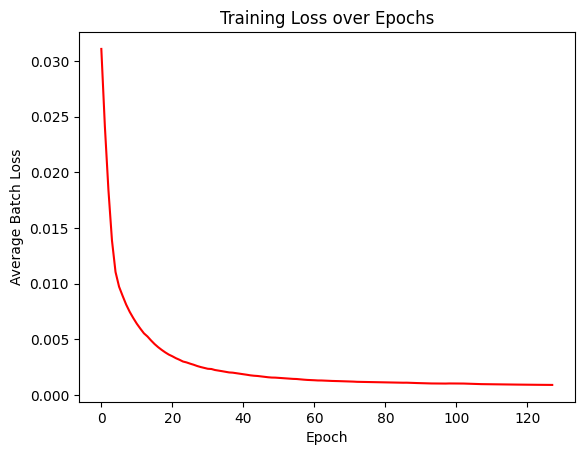

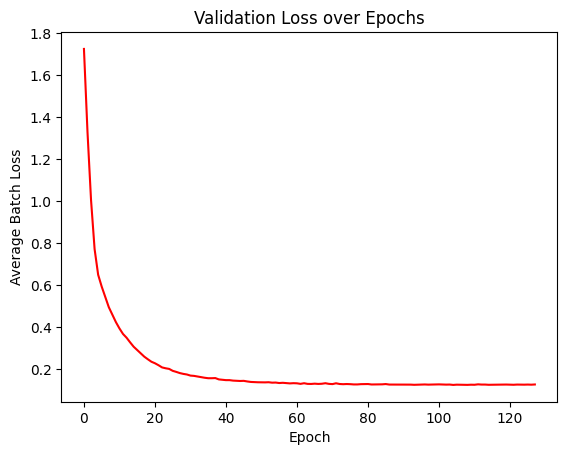

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.031672
Avg batch PSNR: 21.505780
Avg batch SSIM: 0.897885

TRAINING RECONSRTUCTION MODEL FOR: 5tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.461267
-------------------------------
Epoch 8

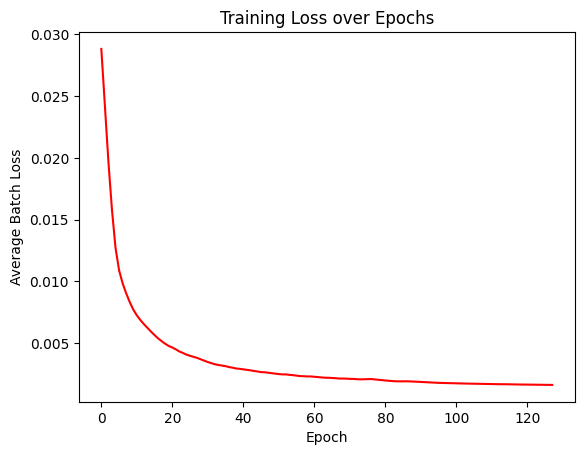

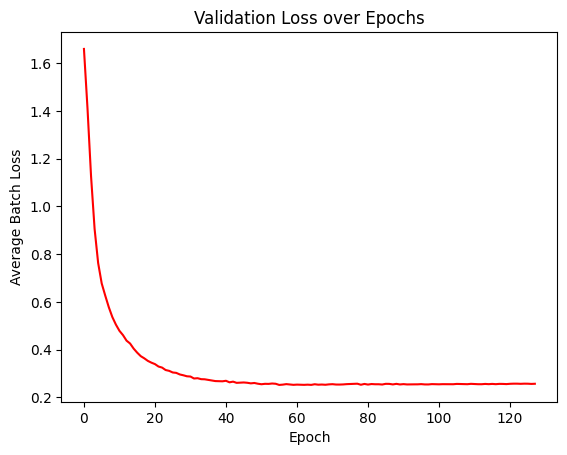

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.064166
Avg batch PSNR: 17.855935
Avg batch SSIM: 0.795221

TRAINING RECONSRTUCTION MODEL FOR: a25n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.506205
-------------------------------
Epoch 8

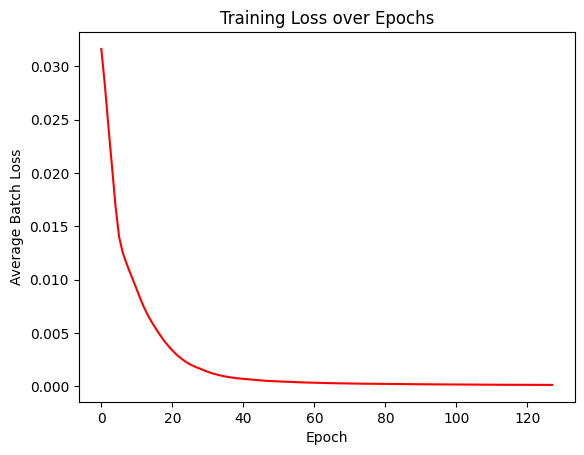

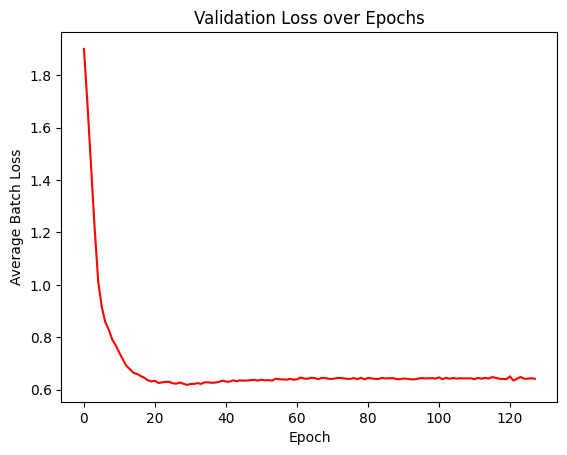

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.160379
Avg batch PSNR: 14.071206
Avg batch SSIM: 0.429051

TRAINING RECONSRTUCTION MODEL FOR: 100n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.484214
-------------------------------
Epoch 8

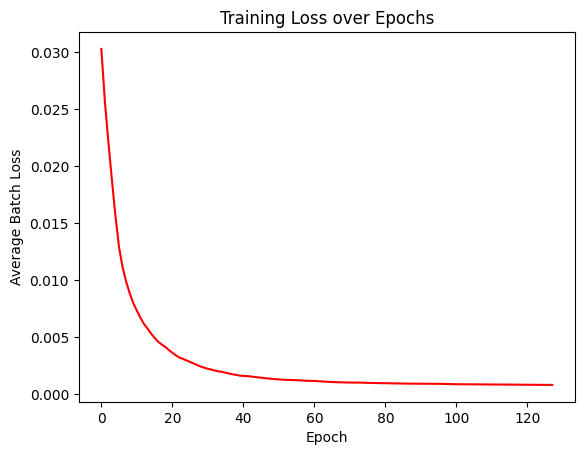

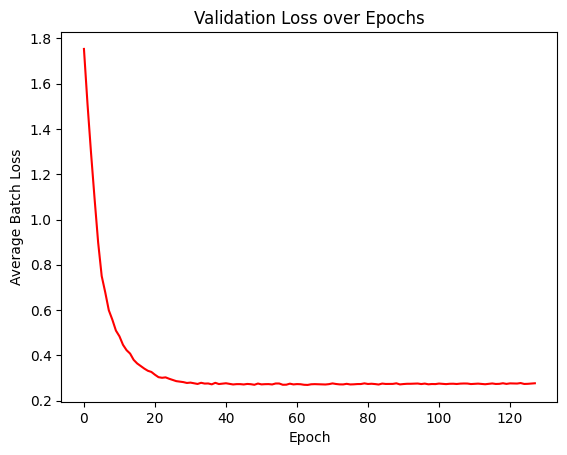

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.069166
Avg batch PSNR: 17.503658
Avg batch SSIM: 0.756681

TRAINING RECONSRTUCTION MODEL FOR: 37n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.475934
-------------------------------
Epoch 8


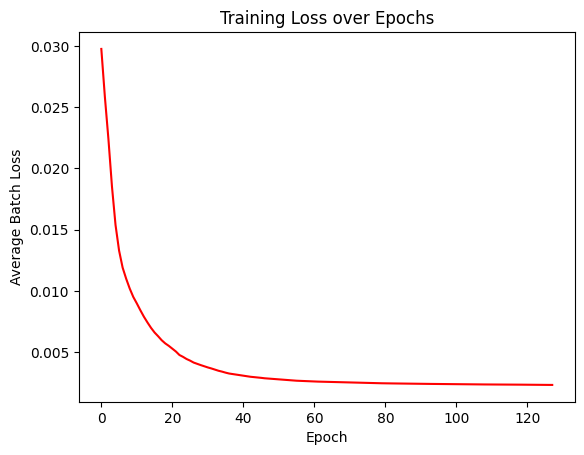

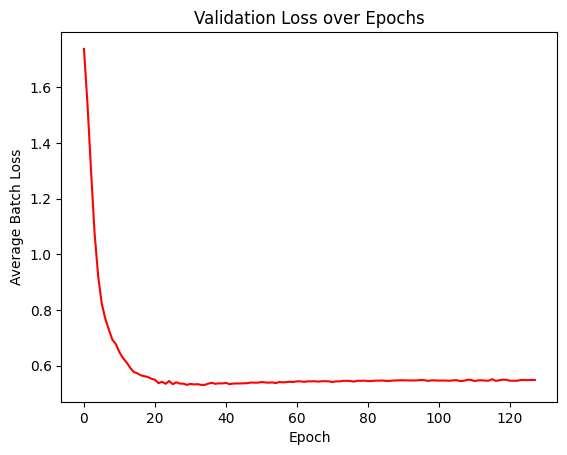

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.137055
Avg batch PSNR: 14.250401
Avg batch SSIM: 0.501136

TRAINING RECONSRTUCTION MODEL FOR: 50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.517659
-------------------------------
Epoch 8


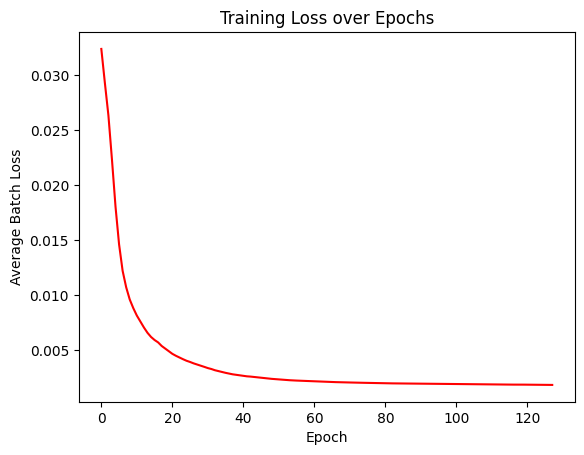

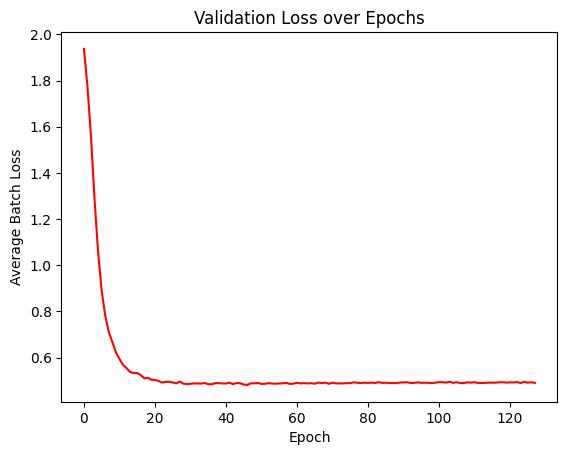

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.122462
Avg batch PSNR: 14.835447
Avg batch SSIM: 0.556101

TRAINING RECONSRTUCTION MODEL FOR: 62n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.509204
-------------------------------
Epoch 8


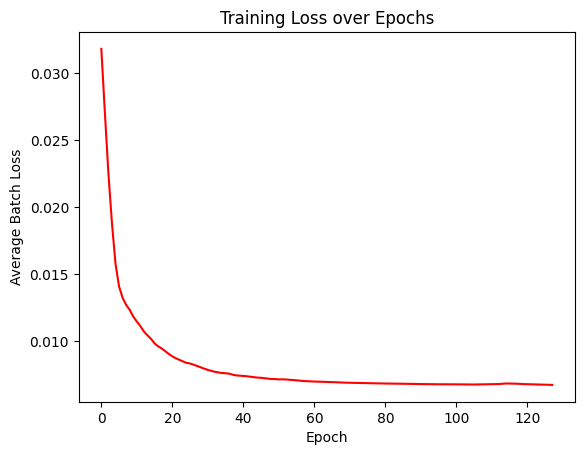

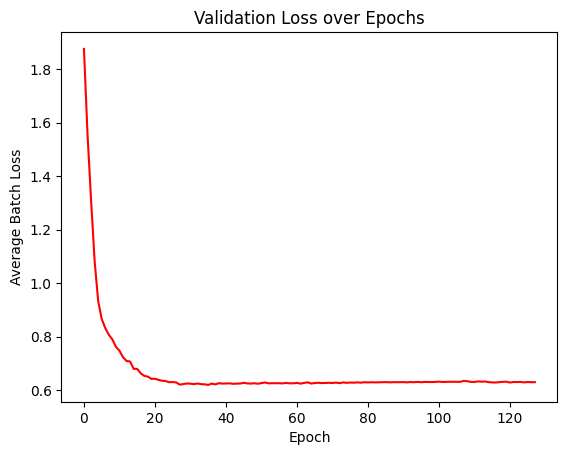

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.157559
Avg batch PSNR: 13.837149
Avg batch SSIM: 0.428341

TRAINING RECONSRTUCTION MODEL FOR: 75n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.485402
-------------------------------
Epoch 8


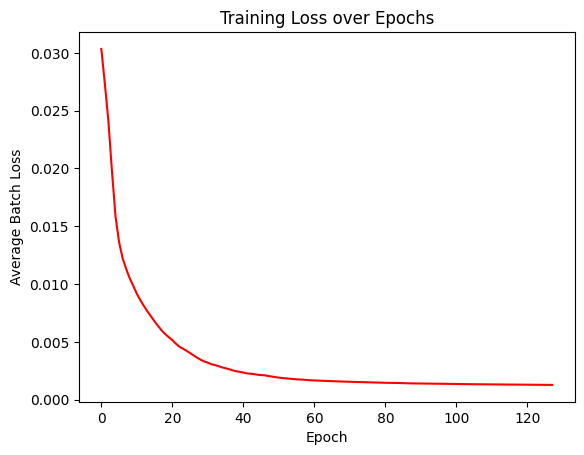

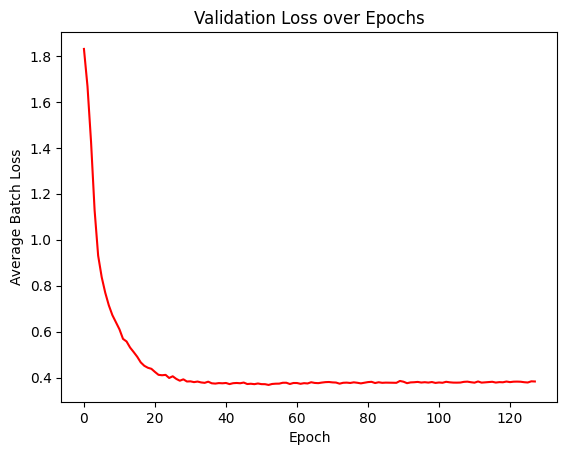

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.095944
Avg batch PSNR: 16.077016
Avg batch SSIM: 0.653547

TRAINING RECONSRTUCTION MODEL FOR: 87p5n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.511893
-------------------------------
Epoch 

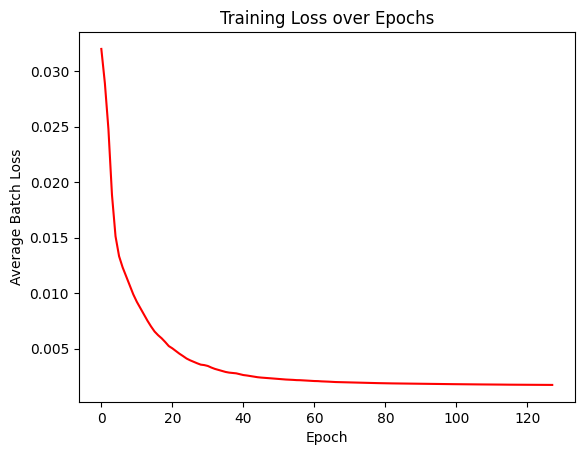

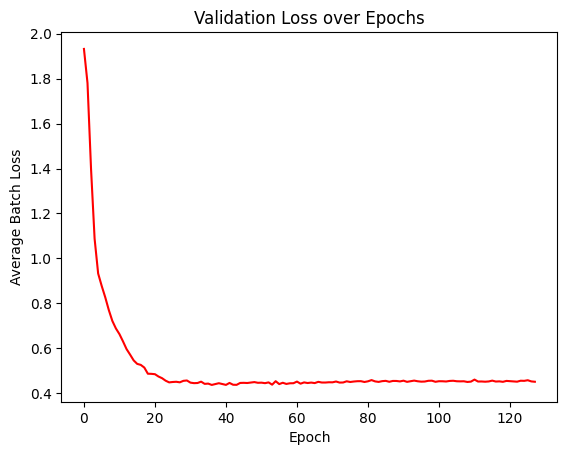

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.112720
Avg batch PSNR: 15.261867
Avg batch SSIM: 0.608294

TRAINING RECONSRTUCTION MODEL FOR: 10fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.462023
-------------------------------
Epoch 8

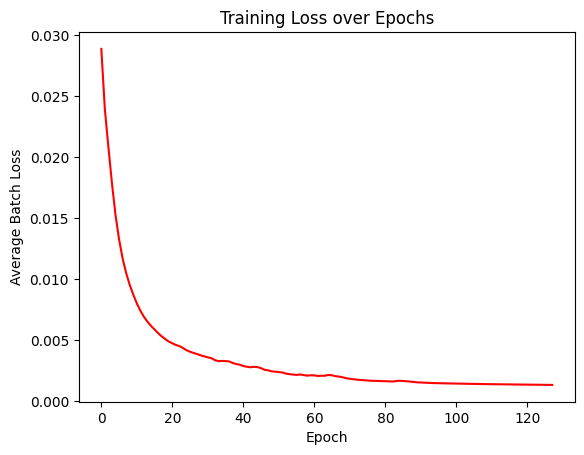

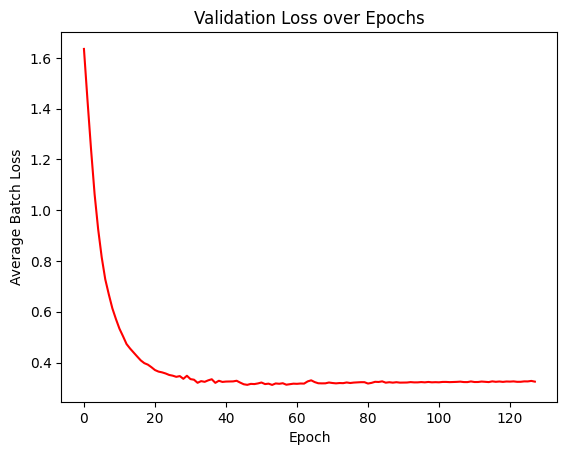

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.081177
Avg batch PSNR: 16.779326
Avg batch SSIM: 0.728319

TRAINING RECONSRTUCTION MODEL FOR: 3fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.388426
-------------------------------
Epoch 8


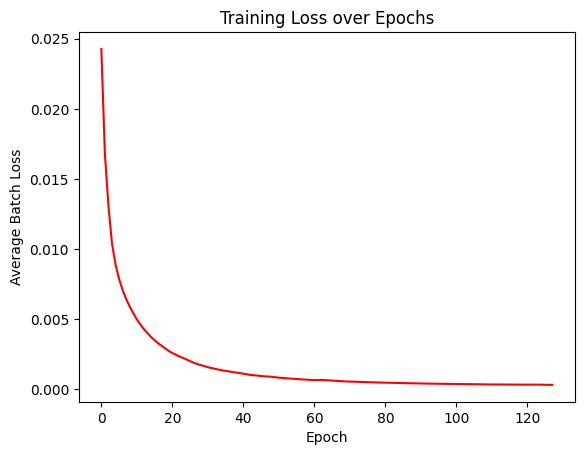

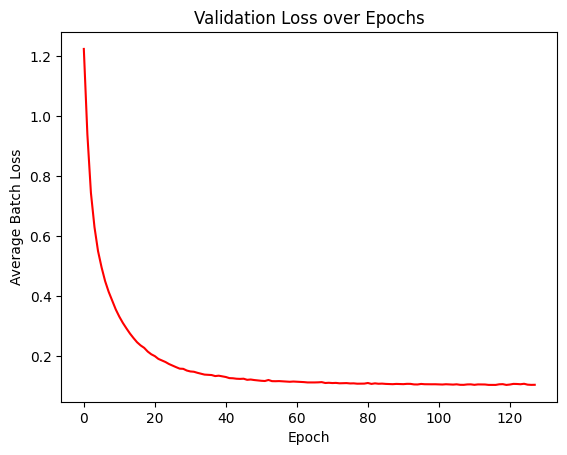

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.026417
Avg batch PSNR: 22.341267
Avg batch SSIM: 0.911076

TRAINING RECONSRTUCTION MODEL FOR: 7a5fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.500798
-------------------------------
Epoch 

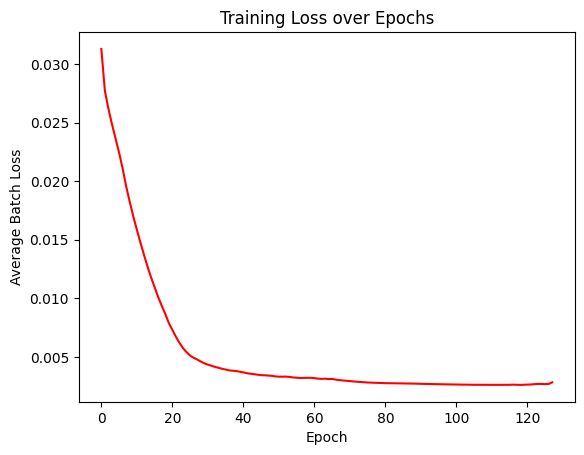

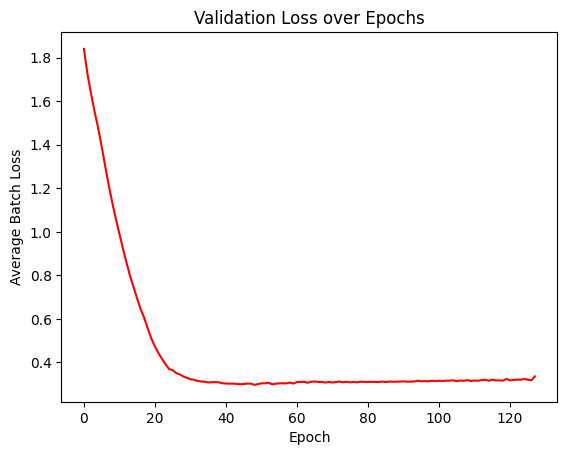

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.083971
Avg batch PSNR: 16.393338
Avg batch SSIM: 0.705196

TRAINING RECONSRTUCTION MODEL FOR: aa15fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.488395
-------------------------------
Epoch

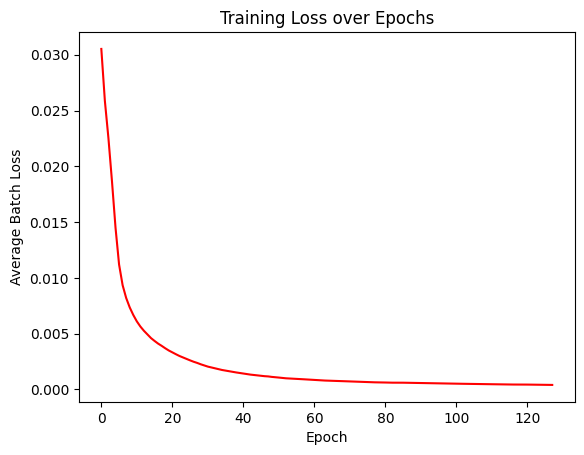

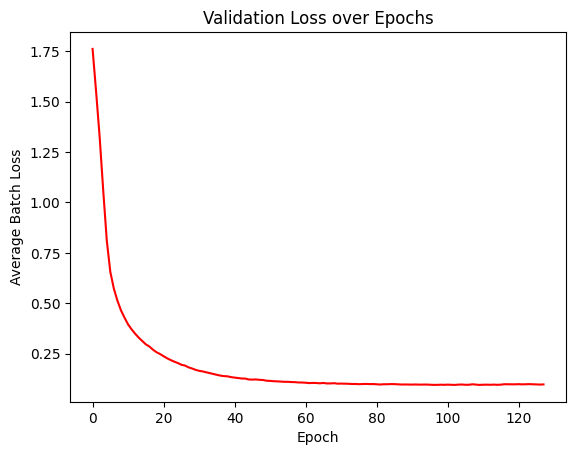

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.024479
Avg batch PSNR: 22.626352
Avg batch SSIM: 0.920057

TRAINING RECONSRTUCTION MODEL FOR: aa20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.483981
-------------------------------
Epoch

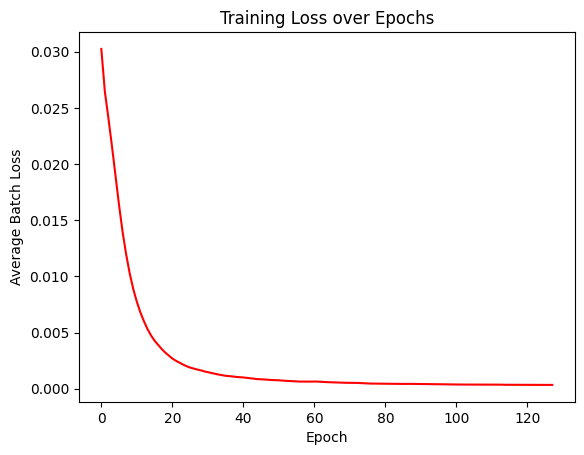

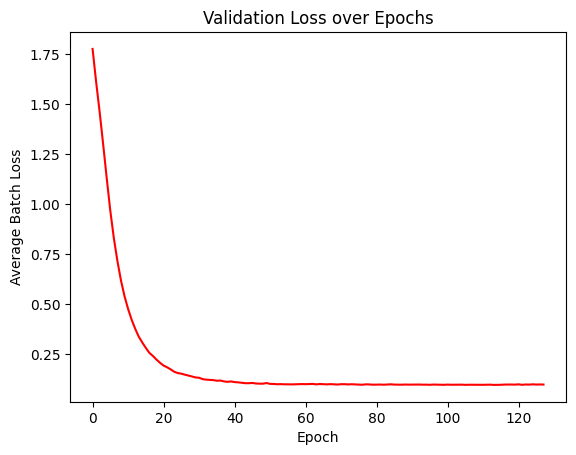

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.024521
Avg batch PSNR: 22.904842
Avg batch SSIM: 0.924080

TRAINING RECONSRTUCTION MODEL FOR: aa25fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.460743
-------------------------------
Epoch

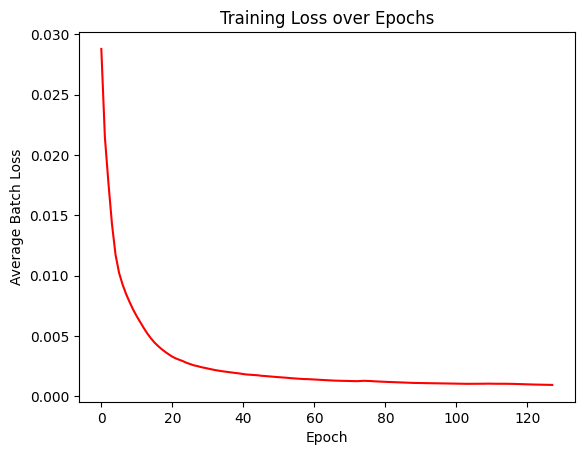

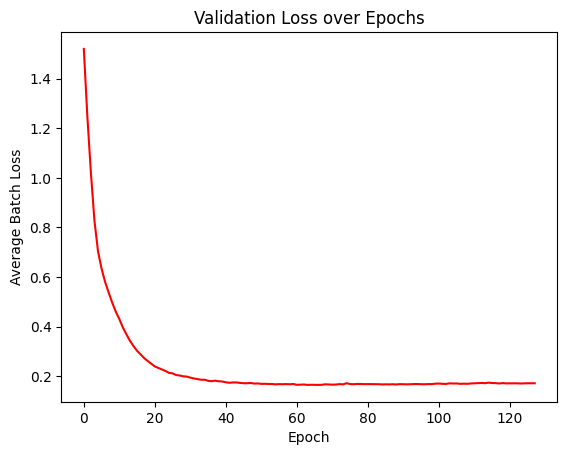

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.043024
Avg batch PSNR: 19.753526
Avg batch SSIM: 0.860714

TRAINING RECONSRTUCTION MODEL FOR: aa30fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.534425
-------------------------------
Epoch

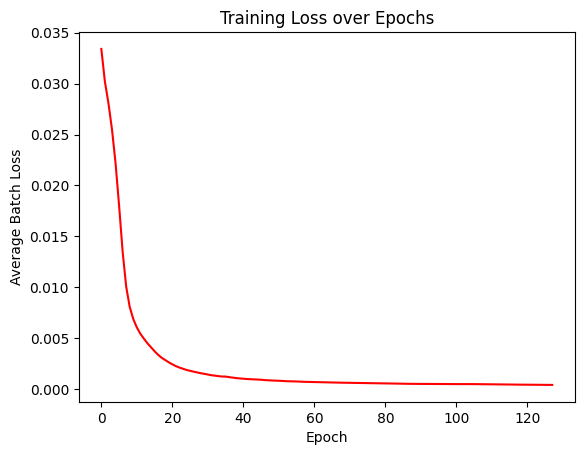

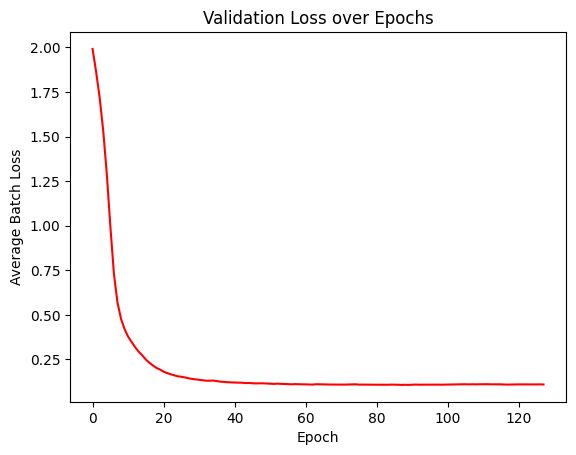

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.027210
Avg batch PSNR: 21.954034
Avg batch SSIM: 0.913604

TRAINING RECONSRTUCTION MODEL FOR: aa35fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.453432
-------------------------------
Epoch

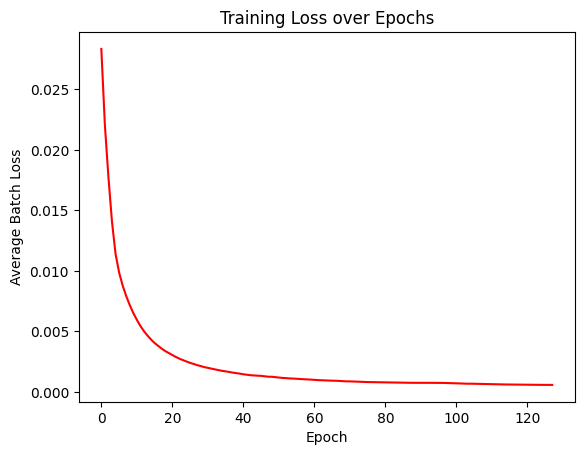

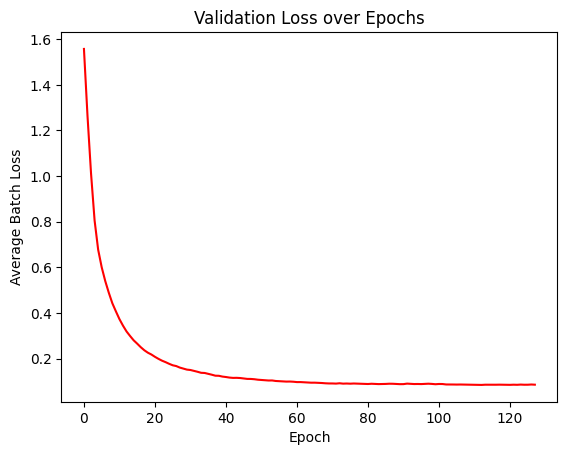

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.021385
Avg batch PSNR: 23.345962
Avg batch SSIM: 0.931144

TRAINING RECONSRTUCTION MODEL FOR: aa40fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.466266
-------------------------------
Epoch

Exception: ignored

In [ ]:
# hyper parameters
batch_size = 50
val_size = 0.2
epochs = 128
learning_rate = 1e-3
loss_fn = L1_SSIM_loss(window_size=2, n_channels=1).cuda()

###############################################################################
# IMAGE RECONSTRUCTION
###############################################################################

# VARIED NOISE LEVELS
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/ASE_noise/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/ASE_noise/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = '../data/features/ASE_noise/reconstruction_results.csv'
results.to_csv(filename, index=False)


# VARIED INTEGRATION TIMES
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/integration_time/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/integration_time/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = '../data/features/integration_time/reconstruction_results.csv'
results.to_csv(filename, index=False)


TRAINING RECONSRTUCTION MODEL FOR: annd40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=50176, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 224, 224))
    (7): Conv2d(1, 4, kernel_size=(8, 8), stride=(1, 1), padding=(4, 4))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(16, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(4, 1, kernel_size=(1, 1), stride=(1, 1))
  

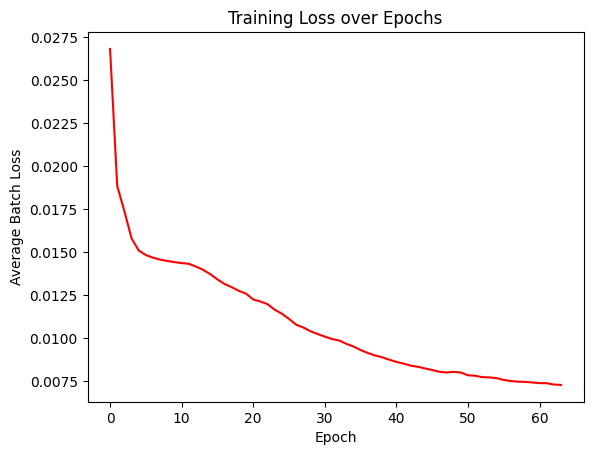

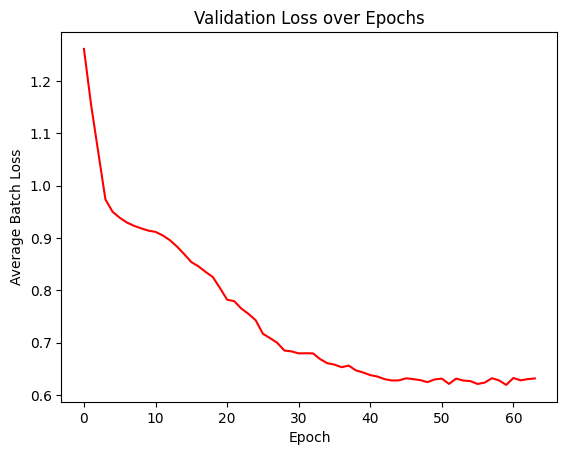

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.157962
Avg batch PSNR: 13.780306
Avg batch SSIM: 0.422636

TRAINING RECONSRTUCTION MODEL FOR: 0p5tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=50176, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 224, 224))
    (7): Conv2d(1, 4, kernel_size=(8, 8), stride=(1, 1), padding=(4, 4))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(16, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

KeyboardInterrupt: ignored

In [ ]:
# hyper parameters
batch_size = 50
val_size = 0.2
epochs = 64
learning_rate = 1e-3
loss_fn = L1_SSIM_loss(window_size=2, n_channels=1).cuda()

###############################################################################
# IMAGE RECONSTRUCTION + CLASSIFICATION (ONE MODEL)
###############################################################################

# VARIED NOISE LEVELS
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/ASE_noise/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/ASE_noise/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = '../data/features/ASE_noise/reconstruction_results.csv'
results.to_csv(filename, index=False)


# VARIED INTEGRATION TIMES
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/integration_time/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/integration_time/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = '../data/features/integration_time/reconstruction_results.csv'
results.to_csv(filename, index=False)